In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import astropy.coordinates as coord
from astropy.table import Table, vstack
from astropy.io import fits
import astropy.units as u

import gala.coordinates as gc

In [2]:
plt.style.use('notebook')

In [3]:
t = Table(fits.getdata('../data/pal5_ls_lite.fits'))

In [4]:
a2ebv = [3.995, 3.214, 2.165, 1.592, 1.211, 1.064]
bands = ['u', 'g', 'r', 'i', 'z', 'Y']

In [5]:
t

<Table length=23942933>
        ra                 dec            flux_g     flux_r       ebv    
     float64             float64         float32    float32     float32  
------------------ ------------------- ----------- ---------- -----------
226.52426847551567  -8.874216536577661    4.240543  16.516861 0.097645864
226.52008530185287  -8.872397535073175   2.7472446  5.8089075  0.09751192
 226.5882022560498   -8.87218668427637    5.526731   5.345809  0.09622228
226.65806032897706  -8.872484178653915   1.6096841   2.319358  0.09309858
 226.6592005340031  -8.873259293835117   0.3493771   1.937863 0.093133844
226.65628344603317  -8.872523708857836  0.20894288 0.50652343  0.09316877
  226.658285272896  -8.870458266883263   4.9841657   9.425405  0.09288682
 226.5898133338899  -8.867903865783541    2.870485  10.714003  0.09575036
 226.5926077778956  -8.873208027222665   3.1388447  10.577626  0.09610162
  226.591935059631  -8.863121507502921   164.57512   657.4187 0.095222466
               ...                 ...         ...        ...         ...
216.47402852741308  -7.126736898044868  0.12037252 0.19222516  0.04640543
216.48748654934883  -7.126062478558054  0.71770936   2.601536 0.046550296
216.41403882577507  -7.126354936341399  0.08400303 0.17741017 0.045773137
216.39382632746518 -7.1262031296564485  0.16538258 0.22111556 0.045491386
216.29520670160386  -7.126302837518312    0.046402  0.1749979 0.044922497
216.25413469823044  -7.125573117730476 0.097161256 0.41808543  0.04422035
 216.2901786534875  -7.125781047623942 0.057797834 0.14607354 0.044925507
216.35772692761824   -7.12562589078928 0.120897196 0.18027492 0.045194514
216.26242003003284   -7.12558587912247  0.05723799 0.31505424 0.044502735
216.34498847862776  -7.125045481716204  0.03655993  0.1602153  0.04519904

In [6]:
g = 22.5 - 2.5*np.log10(t['flux_g']) - t['ebv']*a2ebv[1]
r = 22.5 - 2.5*np.log10(t['flux_r']) - t['ebv']*a2ebv[2]

/home/ana/install/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/home/ana/install/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
/home/ana/install/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/ana/install/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


In [7]:
ceq = coord.SkyCoord(ra=t['ra']*u.deg, dec=t['dec']*u.deg, frame='icrs')

In [8]:
cpal = ceq.transform_to(gc.Pal5)
cgal = ceq.galactic

In [9]:
phi2_mask = np.abs(cpal.phi2)<1*u.deg

In [10]:
points = np.array([g-r, g]).T

In [16]:
# iso = Table.read('../data/mist_12.0_-1.50.cmd', format='ascii.commented_header', header_start=12)
iso = Table.read('../data/mist_11.5_-1.30.cmd', format='ascii.commented_header', header_start=12)
phasecut = (iso['phase']>=0) & (iso['phase']<5)
iso = iso[phasecut]

In [20]:
# distance modulus
distance_app = 22.5*u.kpc
# distance_app = 18.5*u.kpc
dm = 5*np.log10((distance_app.to(u.pc)).value)-5

# main sequence + rgb
i_gr = iso['DECam_g']-iso['DECam_r'] + 0.06
i_g = iso['DECam_g']+dm
i_r = iso['DECam_r']+dm

i_left = i_gr - 0.12*(i_g/28)**5
i_right = i_gr + 0.12*(i_g/28)**5

poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
ind = (poly[:,1]<23.7) & (poly[:,1]>20)
poly_main = poly[ind]
path_main = mpl.path.Path(poly_main)

In [18]:
ra0 = 229.022083*u.deg
dec0 = -0.111389*u.deg
cluster_mask = np.sqrt((ceq.ra-ra0)**2 + (ceq.dec-dec0)**2)<0.5*u.deg

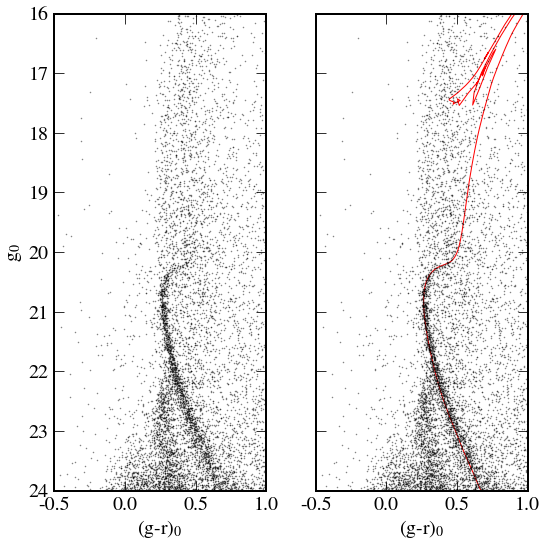

In [23]:
fig, ax = plt.subplots(1,2,figsize=(8,8), sharey=True, sharex=True)

plt.sca(ax[0])
plt.plot(g[cluster_mask] - r[cluster_mask], 
         g[cluster_mask], 'k.', ms=1, alpha=0.5)

plt.xlim(-0.5,1)
plt.ylim(24,16)
plt.xlabel('(g-r)$_0$')
plt.ylabel('$g_0$')

plt.sca(ax[1])
plt.plot(g[cluster_mask] - r[cluster_mask], 
         g[cluster_mask], 'k.', ms=1, alpha=0.5)

plt.plot(i_gr, i_g, 'r-', lw=1, zorder=0, label='11.5 Gyr\n[Fe/H]=$-1.3$')
# pm = mpl.patches.Polygon(poly_main, color='none', ec='orange', zorder=2, label='')
# plt.gca().add_artist(pm)

plt.xlim(-0.5,1)
plt.ylim(24,16)
plt.xlabel('(g-r)$_0$')

plt.tight_layout()
plt.savefig('../plots/cmd_cluster.png')

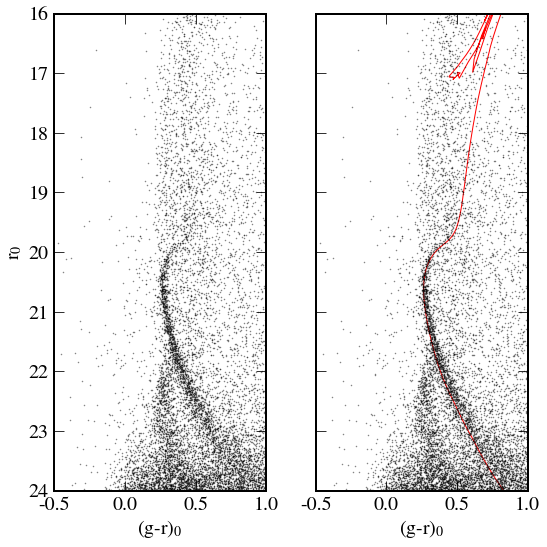

In [22]:
fig, ax = plt.subplots(1,2,figsize=(8,8), sharey=True, sharex=True)

plt.sca(ax[0])
plt.plot(g[cluster_mask] - r[cluster_mask], 
         r[cluster_mask], 'k.', ms=1, alpha=0.5)

plt.xlim(-0.5,1)
plt.ylim(24,16)
plt.xlabel('(g-r)$_0$')
plt.ylabel('$r_0$')

plt.sca(ax[1])
plt.plot(g[cluster_mask] - r[cluster_mask], 
         r[cluster_mask], 'k.', ms=1, alpha=0.5)

plt.plot(i_gr, i_r, 'r-', lw=1, zorder=0, label='11.5 Gyr\n[Fe/H]=$-1.3$')
# pm = mpl.patches.Polygon(poly_main, color='none', ec='orange', zorder=2, label='')
# plt.gca().add_artist(pm)

plt.xlim(-0.5,1)
plt.ylim(24,16)
plt.xlabel('(g-r)$_0$')

plt.tight_layout()

In [34]:
# distance modulus
distance_app = 22.5*u.kpc
distance_app = 19*u.kpc
dm = 5*np.log10((distance_app.to(u.pc)).value)-5

# main sequence + rgb
i_gr = iso['DECam_g']-iso['DECam_r'] + 0.06
i_g = iso['DECam_g']+dm
i_r = iso['DECam_r']+dm

i_left = i_gr - 0.12*(i_g/28)**5
i_right = i_gr + 0.12*(i_g/28)**5

poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
ind = (poly[:,1]<23.7) & (poly[:,1]>20)
poly_main = poly[ind]
path_main = mpl.path.Path(poly_main)

cmd_mask = path_main.contains_points(points)

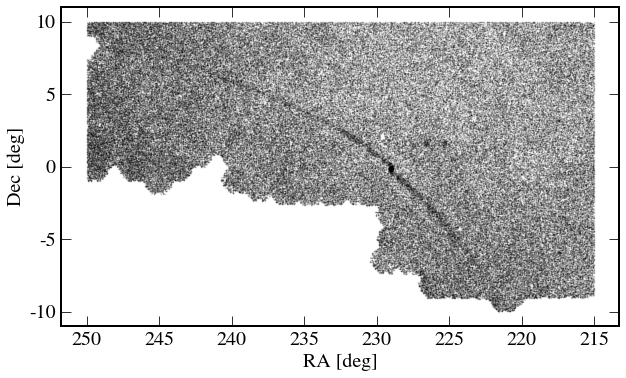

In [35]:
fig, ax = plt.subplots(1,1,figsize=(10,15))

plt.plot(ceq.ra[cmd_mask], ceq.dec[cmd_mask], 'k.', ms=1, alpha=0.15)

plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')

plt.gca().invert_xaxis()
plt.gca().set_aspect('equal')
plt.savefig('../plots/decals_pal5_masks.png', dpi=150)

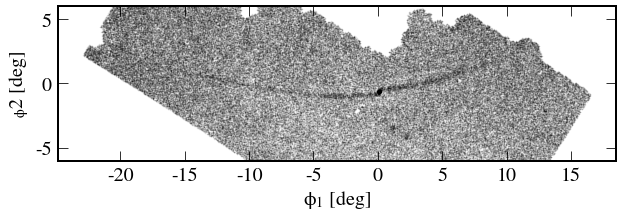

In [36]:
fig, ax = plt.subplots(1,1,figsize=(10,15))

wangle = 180*u.deg
plt.plot(cpal.phi1[cmd_mask].wrap_at(wangle), cpal.phi2[cmd_mask], 'k.', ms=1, alpha=0.1)

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$_\phi2$ [deg]')
plt.ylim(-6,6)

plt.gca().set_aspect('equal')

## CMD of the fan

In [75]:
distance_app = 19*u.kpc
dm = 5*np.log10((distance_app.to(u.pc)).value)-5

# main sequence + rgb
i_gr = iso['DECam_g']-iso['DECam_r'] + 0.06
i_g = iso['DECam_g']+dm

i_left = i_gr - 0.12*(i_g/28)**5
i_right = i_gr + 0.12*(i_g/28)**5

poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
ind = (poly[:,1]<23.7) & (poly[:,1]>20)
poly_main = poly[ind]
path_main = mpl.path.Path(poly_main)

cmd_mask = path_main.contains_points(points)

In [76]:
points_sky = np.array([ceq.ra, ceq.dec]).T

In [78]:
poly_fanw = np.array([[223.75, -5.5], [224.25, -6], [222.25, -9], [221.75,-8.5]]) #+ np.array([0.6,0])
path_fanw = mpl.path.Path(poly_fanw)
fanw_mask = path_fanw.contains_points(points_sky)

# poly_controlw = poly_fanw + np.array([0,4])
poly_controlw = poly_fanw + np.array([-3,0])
path_controlw = mpl.path.Path(poly_controlw)
controlw_mask = path_controlw.contains_points(points_sky)

In [103]:
poly_fan = np.array([[223.5, -5.5], [225.3, -5.5], [224.8, -8.5], [221.5, -8.5]])
path_fan = mpl.path.Path(poly_fan)
fan_mask = path_fan.contains_points(points_sky)

poly_control = poly_fan + np.array([3,14])
path_control = mpl.path.Path(poly_control)
control_mask = path_control.contains_points(points_sky)


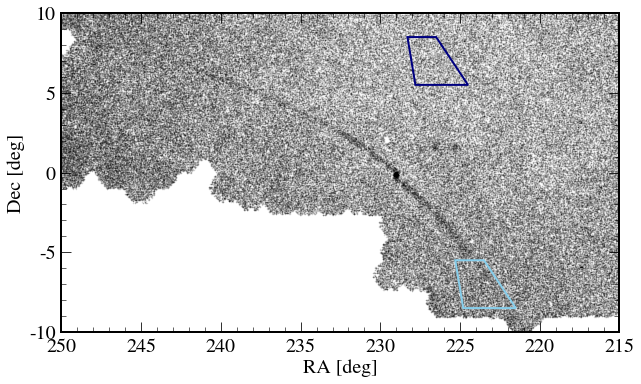

In [146]:
fig, ax = plt.subplots(1,1,figsize=(10,15))

plt.plot(ceq.ra[cmd_mask], ceq.dec[cmd_mask], 'k.', ms=1, alpha=0.15)

# pfanw = mpl.patches.Polygon(poly_fanw, color='none', ec='skyblue', lw=2, alpha=1, zorder=2, label='')
# plt.gca().add_artist(pfanw)
# pcontrolw = mpl.patches.Polygon(poly_controlw, color='none', ec='navy', lw=2, alpha=1, zorder=2, label='')
# plt.gca().add_artist(pcontrolw)

pfan = mpl.patches.Polygon(poly_fan, color='none', ec='skyblue', lw=2, alpha=1, zorder=2, label='')
plt.gca().add_artist(pfan)
pcontrol = mpl.patches.Polygon(poly_control, color='none', ec='navy', lw=2, alpha=1, zorder=2, label='')
plt.gca().add_artist(pcontrol)


plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.xlim(250,215)
plt.ylim(-10,10)
plt.minorticks_on()

plt.gca().set_aspect('equal')

In [105]:
# convert fan selection to galactic coordinates
ceq_fan = coord.SkyCoord(ra=poly_fan[:,0]*u.deg, dec=poly_fan[:,1]*u.deg, frame='icrs')
cgal_fan = ceq_fan.galactic

In [106]:
points_sky_gal = np.array([cgal.l.wrap_at(180*u.deg), cgal.b]).T

In [107]:
poly_fan_gal = np.array([cgal_fan.l.wrap_at(180*u.deg).deg, cgal_fan.b.deg]).T
path_fan_gal = mpl.path.Path(poly_fan_gal)
fan_gal_mask = path_fan_gal.contains_points(points_sky_gal)

In [108]:
poly_control_gal = poly_fan_gal + np.array([24,0])
path_control_gal = mpl.path.Path(poly_control_gal)
control_gal_mask = path_control_gal.contains_points(points_sky_gal)

In [109]:
print(poly_fan_gal)
print(poly_control_gal)

[[-10.23358681  45.93078875]
 [ -8.32363024  44.74415521]
 [-11.57202075  42.80829203]
 [-15.11462238  44.83879829]]
[[13.76641319 45.93078875]
 [15.67636976 44.74415521]
 [12.42797925 42.80829203]
 [ 8.88537762 44.83879829]]


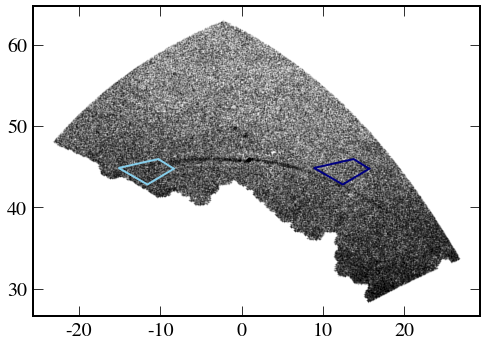

In [110]:
plt.plot(cgal.l[cmd_mask].wrap_at(180*u.deg), cgal.b[cmd_mask], 'k.', ms=1, alpha=0.1)

pfan = mpl.patches.Polygon(poly_fan_gal, color='none', ec='skyblue', lw=2, alpha=1, zorder=2, label='')
plt.gca().add_artist(pfan)

pcontrol = mpl.patches.Polygon(poly_control_gal, color='none', ec='navy', lw=2, alpha=1, zorder=2, label='')
plt.gca().add_artist(pcontrol)

plt.gca().set_aspect('equal')

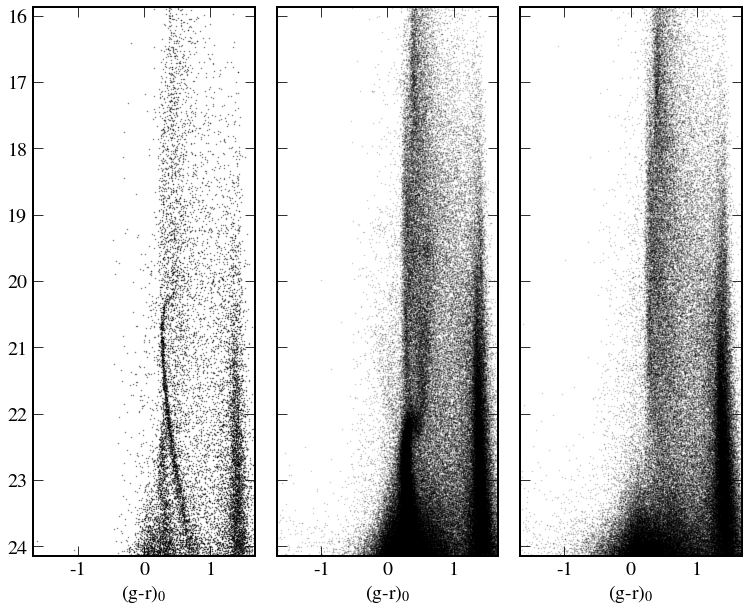

In [147]:
fig, ax = plt.subplots(1,3,figsize=(10.8,9), sharex=True, sharey=True)
plt.sca(ax[0])
plt.plot(g[cluster_mask] - r[cluster_mask], g[cluster_mask], 'k.', ms=1, alpha=0.5)
# plt.plot(i_gr, i_g, 'r-', lw=2, alpha=0.15, zorder=0, label='11.5 Gyr\n[Fe/H]=$-1.3$')

plt.xlim(-1,1)
plt.ylim(24,16)
plt.xlabel('(g-r)$_0$')

plt.sca(ax[1])
plt.plot(g[fan_gal_mask] - r[fan_gal_mask], g[fan_gal_mask], 'k.', ms=1, alpha=0.2)
# plt.plot(i_gr, i_g, 'r-', lw=2, alpha=0.15, zorder=0, label='11.5 Gyr\n[Fe/H]=$-1.3$')

plt.xlim(-1,1)
plt.ylim(24,16)
plt.xlabel('(g-r)$_0$')
plt.gca().set_aspect('equal')

plt.sca(ax[2])
plt.plot(g[control_gal_mask] - r[control_gal_mask], g[control_gal_mask], 'k.', ms=1, alpha=0.2)
# plt.plot(i_gr, i_g, 'r-', lw=2, alpha=0.15, zorder=0, label='11.5 Gyr\n[Fe/H]=$-1.3$')

plt.xlim(-1.5,1.5)
plt.ylim(24,16)
plt.xlabel('(g-r)$_0$')
plt.gca().set_aspect('equal')

plt.tight_layout()

In [113]:
print(np.sum((g-r>1) & control_gal_mask))
print(np.sum((g-r>1) & fan_gal_mask))
print(np.sum((g-r>1) & fan_gal_mask)/np.sum((g-r>1) & control_gal_mask))

/home/ana/install/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


137038
155273
1.1330652811628892


/home/ana/install/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/ana/install/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/ana/install/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


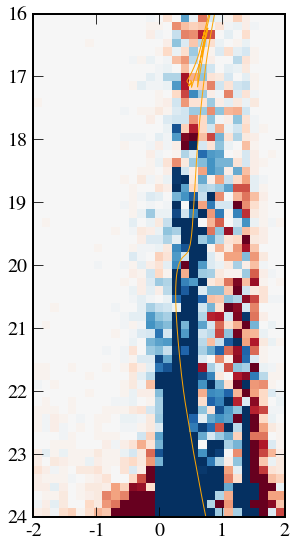

In [116]:
bx = np.linspace(-2,2,30)
by = np.linspace(16,24,60)
h_fanw, bxe, bye = np.histogram2d(g[fan_gal_mask] - r[fan_gal_mask], g[fan_gal_mask], bins=(bx, by))
h_controlw, bxe, bye = np.histogram2d(g[control_gal_mask] - r[control_gal_mask], g[control_gal_mask], bins=(bx, by))

res_fanw = h_fanw - h_controlw

plt.imshow(res_fanw.T, extent=[bxe[0], bxe[-1], bye[-1], bye[0]], cmap='RdBu', vmin=-30, vmax=30)

# res_fanw[res_fanw<0] = 0.1
# plt.imshow(res_fanw.T, extent=[bxe[0], bxe[-1], bye[-1], bye[0]], cmap='RdBu', vmax=70,
#            norm=mpl.colors.LogNorm())

plt.plot(i_gr, i_g, '-', color='orange', lw=1, zorder=2, label='12 Gyr\n[Fe/H]=$-1.35$')

plt.xlim(bxe[0], bxe[-1])
plt.ylim(bye[-1], bye[0])

# plt.axvline(-0.2, color='r', zorder=2)
# plt.axvline(0.1, color='r', zorder=2)

plt.tight_layout()

## Stream density profiles

In [129]:
wangle = 180*u.deg

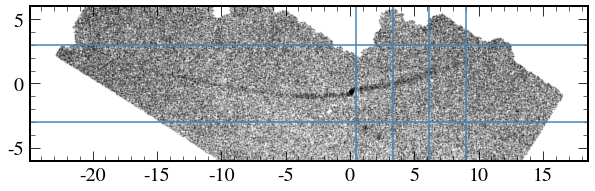

In [145]:
fig, ax = plt.subplots(1,1,figsize=(10,15))

plt.plot(cpal.phi1[cmd_mask].wrap_at(wangle), cpal.phi2[cmd_mask], 'k.', ms=1, alpha=0.1)

phi1_range = np.linspace(0.5,9,4)
for p_ in phi1_range:
    plt.axvline(p_, color='steelblue')

plt.axhline(-3,color='steelblue')
plt.axhline(3,color='steelblue')

# plt.xlabel('RA [deg]')
# plt.ylabel('Dec [deg]')
# plt.xlim(250,215)
plt.ylim(-6,6)
plt.minorticks_on()

plt.gca().set_aspect('equal')

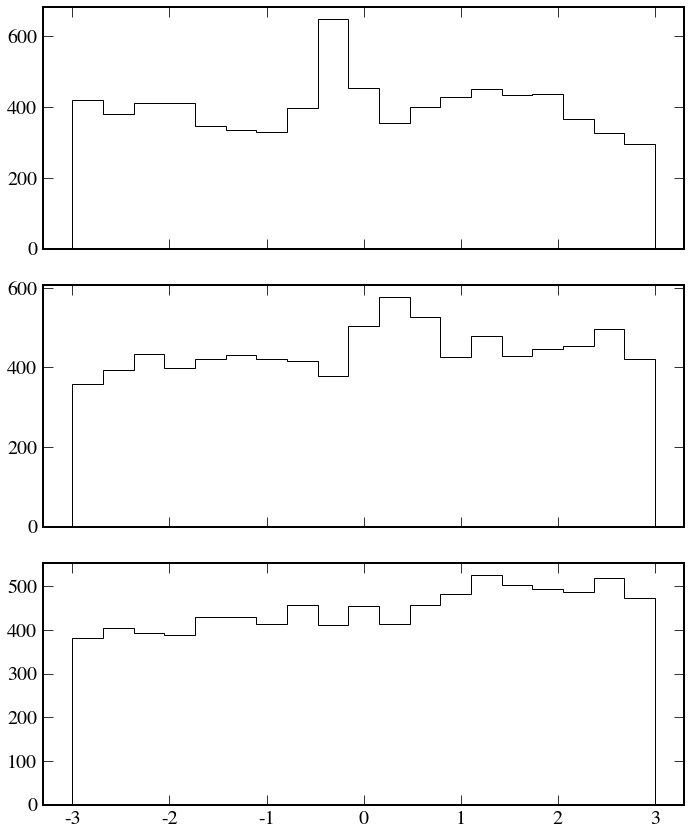

In [142]:
fig, ax = plt.subplots(3,1,figsize=(10,12), sharex=True)

for i in range(3):
    plt.sca(ax[i])
    
    ind = ((cpal.phi1.wrap_at(wangle).deg>phi1_range[i]) & (cpal.phi1.wrap_at(wangle).deg<phi1_range[i+1])
          & (np.abs(cpal.phi2.deg)<3))
    plt.hist(cpal.phi2[cmd_mask & ind], bins=np.linspace(-3,3,20), color='k', histtype='step')
    
plt.tight_layout()

## Stream candidate

In [57]:
distance_app = 20.5*u.kpc
dm = 5*np.log10((distance_app.to(u.pc)).value)-5

# main sequence + rgb
i_gr = iso['DECam_g']-iso['DECam_r'] + 0.06
i_g = iso['DECam_g']+dm

i_left = i_gr - 0.12*(i_g/28)**5
i_right = i_gr + 0.12*(i_g/28)**5

poly = np.hstack([np.array([i_left, i_g]), np.array([i_right[::-1], i_g[::-1]])]).T
ind = (poly[:,1]<23.7) & (poly[:,1]>20)
poly_main = poly[ind]
path_main = mpl.path.Path(poly_main)

cmd_mask = path_main.contains_points(points)

In [82]:
poly_cand = np.array([[222.5, -9], [221.5, -9], [219, -3], [220,-3]])
path_cand = mpl.path.Path(poly_cand)
cand_mask = path_cand.contains_points(points_sky)

poly_ccand = poly_cand + np.array([-1.5,0])
# poly_controlw = poly_fanw + np.array([-3,0])
path_ccand = mpl.path.Path(poly_ccand)
ccand_mask = path_ccand.contains_points(points_sky)

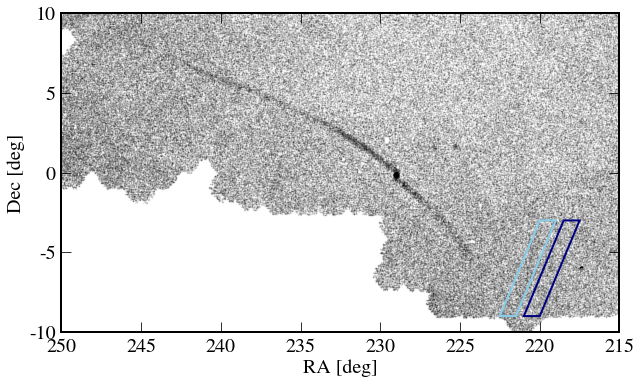

In [83]:
fig, ax = plt.subplots(1,1,figsize=(10,15))

plt.plot(ceq.ra[cmd_mask], ceq.dec[cmd_mask], 'k.', ms=1, alpha=0.1)

pcand = mpl.patches.Polygon(poly_cand, color='none', ec='skyblue', lw=2, alpha=1, zorder=2, label='')
plt.gca().add_artist(pcand)
pccand = mpl.patches.Polygon(poly_ccand, color='none', ec='navy', lw=2, alpha=1, zorder=2, label='')
plt.gca().add_artist(pccand)

plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.xlim(250,215)
plt.ylim(-10,10)

plt.gca().set_aspect('equal')

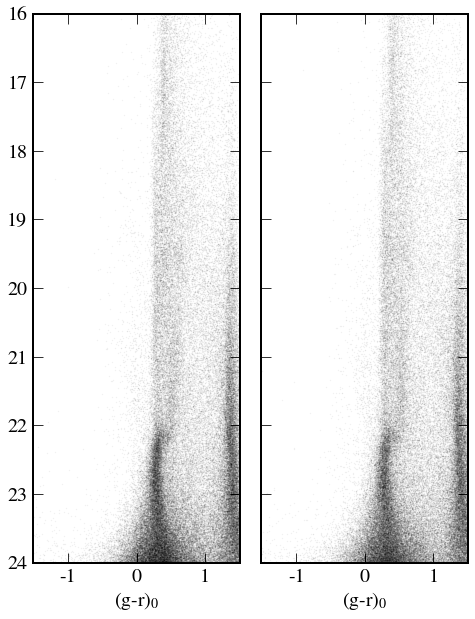

In [84]:
fig, ax = plt.subplots(1,2,figsize=(7,9), sharex=True, sharey=True)

for e, mask in enumerate([cand_mask, ccand_mask]):
    plt.sca(ax[e])
    plt.plot(g[mask] - r[mask], g[mask], 'k.', ms=1, alpha=0.05)
# plt.plot(i_gr, i_g, 'r-', lw=2, alpha=0.15, zorder=0, label='12 Gyr\n[Fe/H]=$-1.35$')

    plt.xlim(-1,1)
    plt.ylim(24,16)
    plt.xlabel('(g-r)$_0$')
    plt.gca().set_aspect('equal')

plt.tight_layout()

/home/ana/install/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/home/ana/install/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/home/ana/install/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


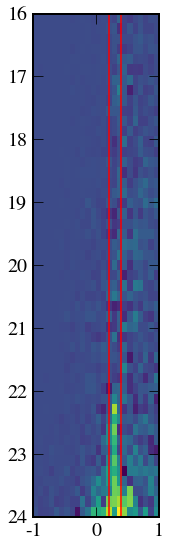

In [103]:
bx = np.linspace(-1,1,25)
by = np.linspace(16,24,50)
h_cand, bxe, bye = np.histogram2d(g[cand_mask] - r[cand_mask], g[cand_mask], bins=(bx, by))
h_ccand, bxe, bye = np.histogram2d(g[ccand_mask] - r[ccand_mask], g[ccand_mask], bins=(bx, by))

res_cand = h_cand - h_ccand

# plt.imshow(res_cand.T, norm=mpl.colors.LogNorm())
plt.imshow(res_cand.T, extent=[bxe[0], bxe[-1], bye[-1], bye[0]])
# plt.imshow(h_cand.T, extent=[bxe[0], bxe[-1], bye[-1], bye[0]])

plt.axvline(0.2, color='r', zorder=2)
plt.axvline(0.4, color='r', zorder=2)

plt.tight_layout()

In [45]:
cand_cmd_mask = (g-r>-0.2) & (g-r<0.1) & (g>20.5) & (g<22)

/home/ana/install/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/home/ana/install/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


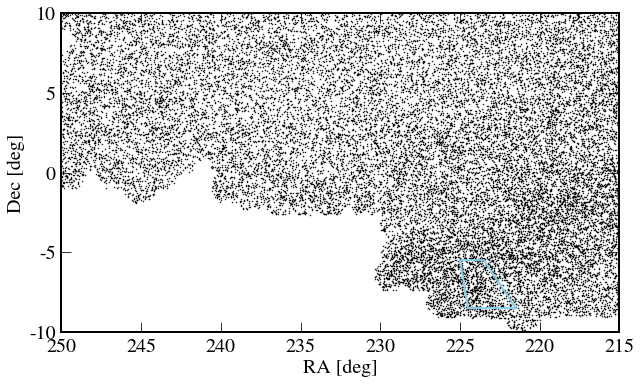

In [47]:
fig, ax = plt.subplots(1,1,figsize=(10,15))

plt.plot(ceq.ra[cand_cmd_mask], ceq.dec[cand_cmd_mask], 'k.', ms=1, alpha=1)

pfan = mpl.patches.Polygon(poly_fan, color='none', ec='skyblue', lw=2, alpha=1, zorder=2, label='')
plt.gca().add_artist(pfan)

plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.xlim(250,215)
plt.ylim(-10,10)

plt.gca().set_aspect('equal')

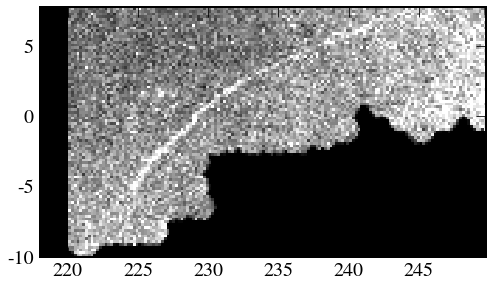

In [55]:
dx = 0.2
bx = np.arange(218,250,dx)
by = np.arange(-10,8,dx)
plt.hist2d(ceq.ra[cmd_mask], ceq.dec[cmd_mask], bins=(bx, by), vmax=35, cmap='gray');

plt.gca().set_aspect('equal')

In [27]:
# save 
tout = Table([ceq.ra[cmd_mask], ceq.dec[cmd_mask]], names=('ra', 'dec'))
tout.write('../data/pal5_distance.{}.fits'.format(distance_app.value), overwrite=True)

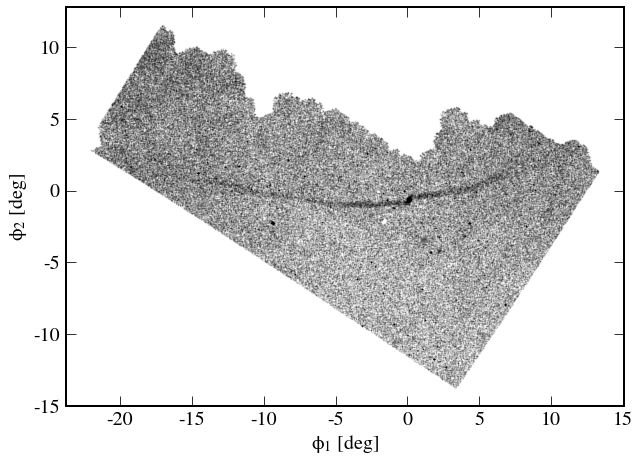

In [28]:
plt.figure(figsize=(10,10))
plt.plot(cpal.phi1.wrap_at(180*u.deg)[cmd_mask], cpal.phi2[cmd_mask], 'k.', ms=1, alpha=0.1)

plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$\phi_2$ [deg]')

# plt.gca().invert_xaxis()
plt.gca().set_aspect('equal')
plt.savefig('../plots/decals_pal5_phi.png', dpi=150)

In [29]:
sw = (ceq.dec<-5*u.deg) & (ceq.ra<225*u.deg)
se = (ceq.dec<-5*u.deg) & (ceq.ra>225*u.deg)

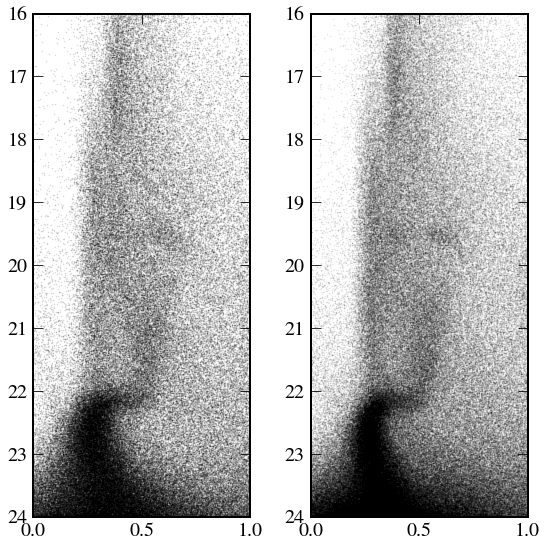

In [30]:
fig, ax = plt.subplots(1,2,figsize=(8,8))

plt.sca(ax[0])
plt.plot(g[se]-r[se], g[se], 'k.', ms=1, alpha=0.15)

# plt.plot(i_gr, i_g, 'r-', lw=2, alpha=0.2, zorder=0, label='12 Gyr\n[Fe/H]=$-1.35$')

plt.xlim(0,1)
plt.ylim(24,16)

plt.sca(ax[1])
plt.plot(g[sw]-r[sw], g[sw], 'k.', ms=1, alpha=0.1)

# plt.plot(i_gr, i_g, 'r-', lw=2, alpha=0.2, zorder=0, label='12 Gyr\n[Fe/H]=$-1.35$')
# pm = mpl.patches.Polygon(poly_main, color='orange', alpha=0.1, zorder=2, label='')
# plt.gca().add_artist(pm)

plt.xlim(0,1)
plt.ylim(24,16)

plt.tight_layout()

## Density map

### Matched filter

In [27]:
ra0 = 229.022083*u.deg
dec0 = -0.111389*u.deg

In [28]:
rcluster = 40*u.arcmin
cluster = np.sqrt((ceq.ra-ra0)**2 + (ceq.dec-dec0)**2)<rcluster

In [29]:
wstream = 1*u.deg
rback_in = 0.8*u.deg
rback_out = 2*u.deg
back = ((np.sqrt((ceq.ra-ra0)**2 + (ceq.dec-dec0)**2)>rback_in) & 
        (np.sqrt((ceq.ra-ra0)**2 + (ceq.dec-dec0)**2)<rback_out) & 
        (np.abs(cpal.phi2)>wstream))

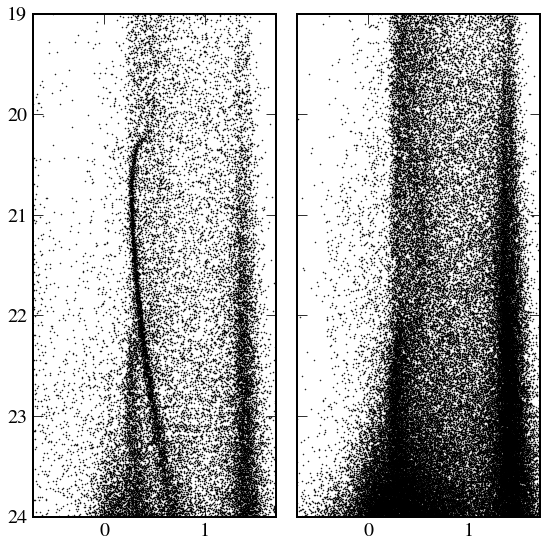

In [30]:
fig, ax = plt.subplots(1,2,figsize=(8,8), sharex=True, sharey=True)

plt.sca(ax[0])
plt.plot(g[cluster]-r[cluster], g[cluster], 'k.', ms=1)
plt.xlim(-0.5,1.5)
plt.ylim(24,19)
plt.gca().set_aspect('equal')

plt.sca(ax[1])
plt.plot(g[back]-r[back], g[back], 'k.', ms=1)

plt.tight_layout()

In [31]:
dx = 0.025
bx = np.arange(-0.5,1.5+dx,dx)
by = np.arange(19,24+dx,dx)
hcluster, bx, by = np.histogram2d(g[cluster]-r[cluster], g[cluster], bins=(bx, by))
hback, bx, by = np.histogram2d(g[back]-r[back], g[back], bins=(bx, by))

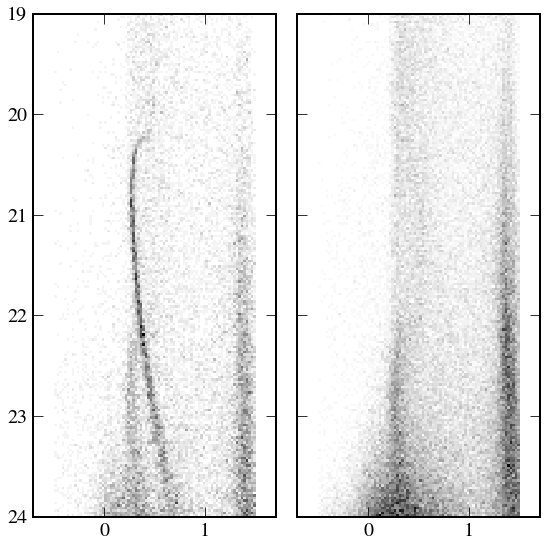

In [32]:
fig, ax = plt.subplots(1,2,figsize=(8,8), sharex=True, sharey=True)
plt.sca(ax[0])
plt.imshow(hcluster.T, cmap='binary', extent=[bx[0], bx[-1], by[-1], by[0]])

plt.sca(ax[1])
plt.imshow(hback.T, cmap='binary', extent=[bx[0], bx[-1], by[-1], by[0]])

plt.tight_layout()

In [33]:
hratio = np.zeros_like(hcluster)
finite = hcluster>0
hratio[finite] = hcluster[finite] / hback[finite]

/home/ana/install/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


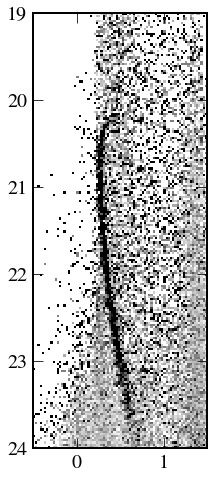

In [34]:
plt.imshow(hratio.T, cmap='binary', extent=[bx[0], bx[-1], by[-1], by[0]], vmax=1)

### Rectangular grid

### Healpix grid

In [35]:
import healpy as hp

In [36]:
def gen_fast_map(ip_, nside):
    npixel  = hp.nside2npix(nside)
    map_ = np.bincount(ip_, minlength=npixel)
    return map_

(196608,)


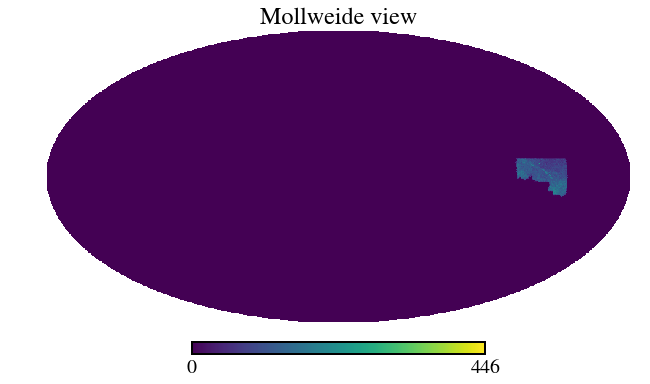

In [37]:
nside = 2**7
ids = hp.ang2pix(nside, ceq[cmd_mask].ra.to(u.deg).value, ceq[cmd_mask].dec.to(u.deg).value, lonlat=True)
n = gen_fast_map(ids, nside)
print(np.shape(n))
hp.visufunc.mollview(n)

# plt.xlim(250, 219)
# plt.ylim(-10, 10)
plt.savefig('../plots/pal5_hp.pdf')

In [38]:
hp.nside2npix(nside)

196608

In [39]:
2**11

2048

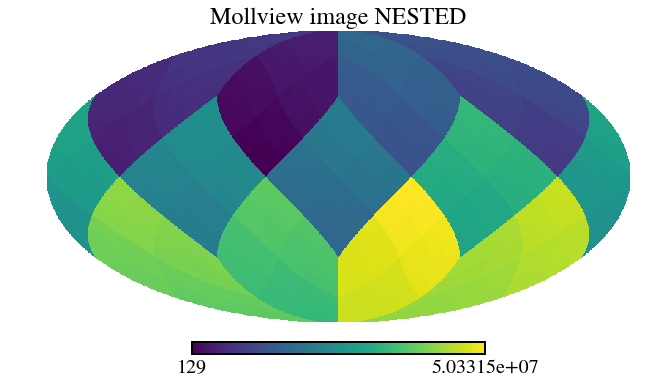

In [40]:
NSIDE = 2**11
m = np.arange(hp.nside2npix(NSIDE))
hp.mollview(m, nest=True, title="Mollview image NESTED")
plt.savefig('../plots/test.pdf')